# Vattenfall RNN prediction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

## 1, Load the data

In [108]:
#from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

df = pd.read_csv('vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[1]

In [151]:
df[['time', 'guide_open']][0:10:2]

,time,guide_open
0,0.0004,0.897672
2,0.0012,0.882785
4,0.0020,0.897672
6,0.0028,0.841845
8,0.0036,0.860454


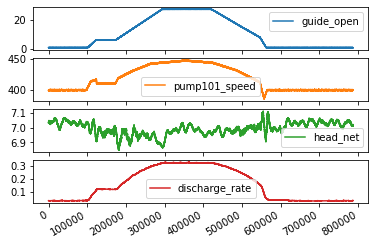

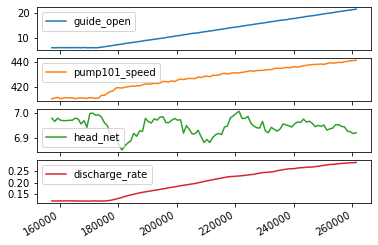

In [153]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True)

plot_features = df[plot_cols][int(len(df)/5):int(len(df)/3):1000]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True)

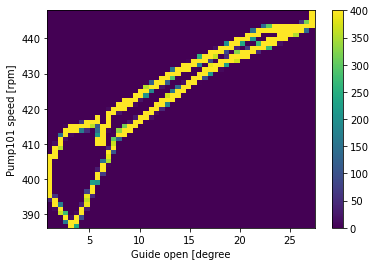

(386.21013, 447.92068600000005, 385.579537, 448.09854)

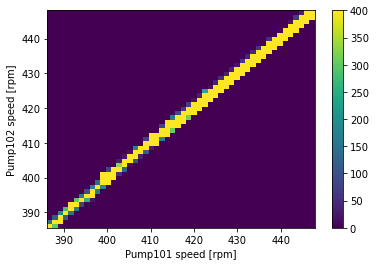

In [159]:
plt.hist2d(df['guide_open'], df['pump101_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Guide open [degree')
plt.ylabel('Pump101 speed [rpm]')
ax = plt.gca()
ax.axis('tight')
plt.show()

plt.hist2d(df['pump101_speed'], df['pump102_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Pump101 speed [rpm]')
plt.ylabel('Pump102 speed [rpm]')
ax = plt.gca()
ax.axis('tight')

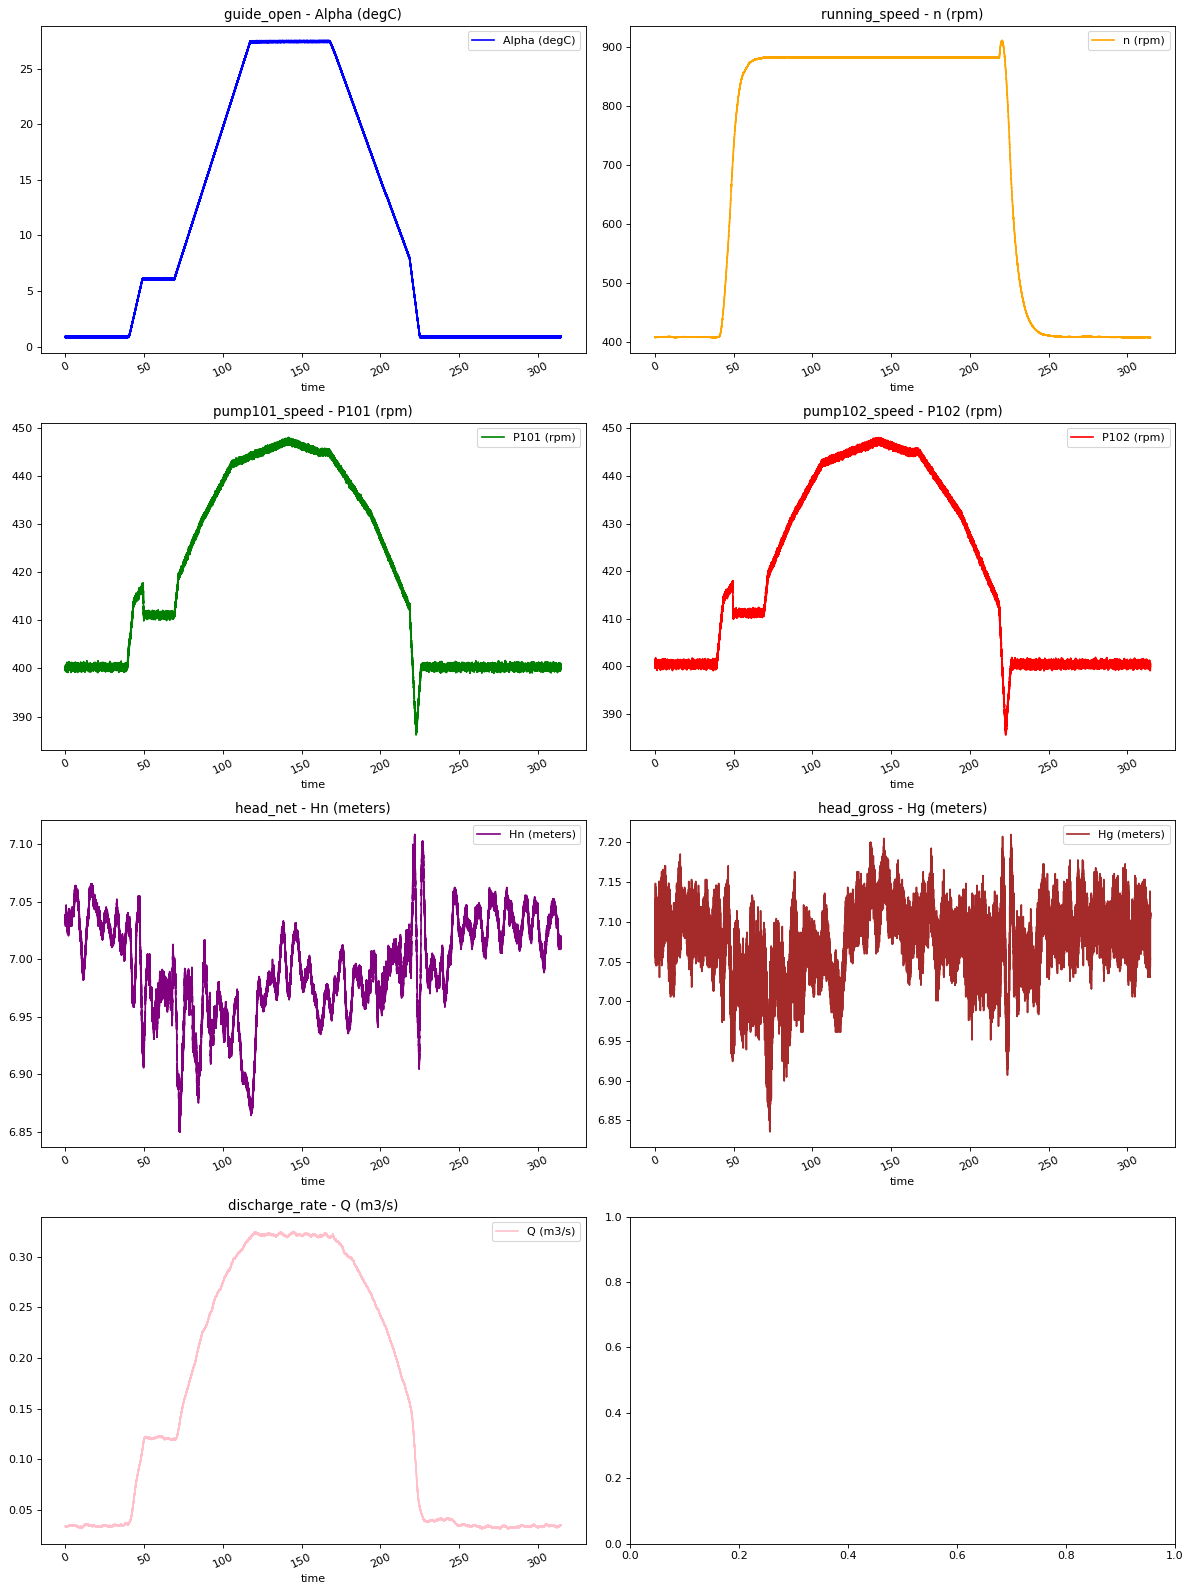

In [6]:
show_raw_visualization(df, df_data)

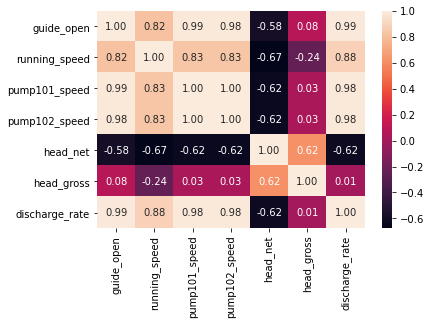

In [7]:
import seaborn as sns
sns.heatmap(df_data.corr(), annot=True, fmt=".2f")
plt.show()

## 2, Preprocess the data (clean and split the data) for training and validation

### 2.1, be careful to select parameters in this procedure

In [216]:
feature_keys
input_keys = feature_keys[[0, 1, 2, 4, 6]]
output_key = feature_keys[0]
print(input_keys, output_key)
input_df = df[input_keys][0:len(df):100]
output_df = df[output_key][0:len(df):100]

# split the data into 70% for training, 20% for validation, and 10% for testing
n = len(df)
train_df = input_df[0:int(n*0.7)]
val_df = input_df[int(n*0.7):int(n*0.9)]
test_df = input_df[int(n*0.9):]

num_features = df.shape[1]

['guide_open' 'running_speed' 'pump101_speed' 'head_net' 'discharge_rate'] guide_open


In [3]:
from IPython.display import Markdown

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

### 2.2, normalize the data

In [217]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

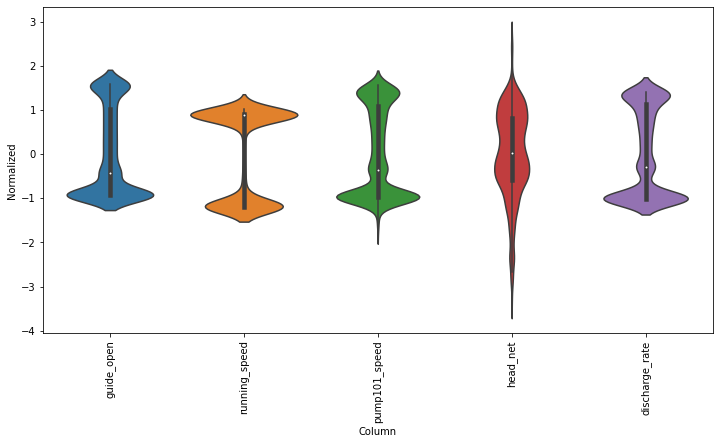

In [222]:
train_mean = train_df.mean()
train_std = train_df.std()

df_std = (train_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(input_df.keys(), rotation=90)

In [221]:
train_mean

guide_open         10.773071
running_speed     679.285443
pump101_speed     418.524643
head_net            6.992708
discharge_rate      0.155963
dtype: float64

### <font color='blue'> **2.3, index and offset for the model fitting (NB: important to adjust)** </font>

In [223]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [243]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['guide_open'])
w1

w2 = WindowGenerator(input_width=200, label_width=1, shift=1,
                     label_columns=['guide_open'])
w2

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200]
Label column name(s): ['guide_open']

In [239]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [244]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 201, 5)
Inputs shape: (3, 200, 5)
Labels shape: (3, 1, 1)


In [245]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='guide_open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

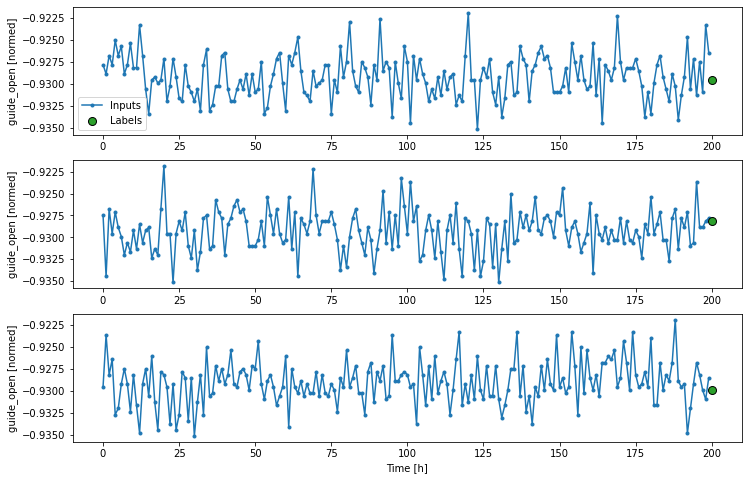

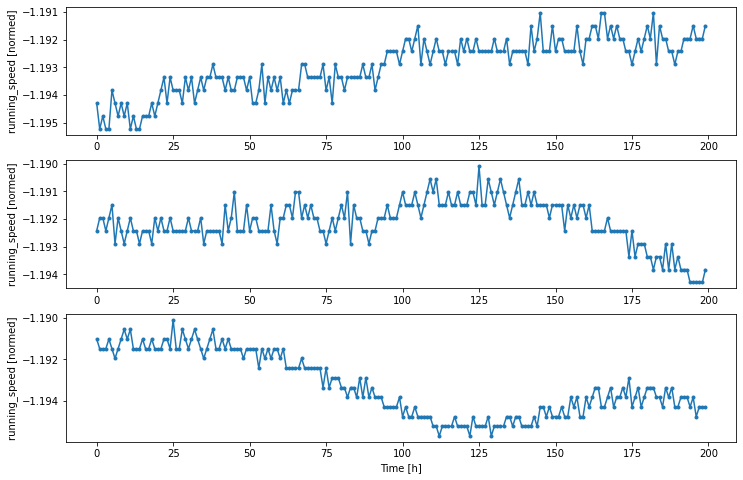

In [246]:
w2.plot()
w2.plot(plot_col='running_speed')

## 2.4, Create tf.data.Datasets

In [259]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [260]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [277]:
w2

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200]
Label column name(s): ['guide_open']

In [276]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 200, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [262]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 200, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [272]:
single_step_window = WindowGenerator(
    input_width=10, label_width=1, shift=1,
    label_columns=['guide_open'])
single_step_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['guide_open']

In [264]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


## 3, Baseline model

In [265]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [269]:
column_indices['guide_open']

0

In [273]:
column_indices = {name: i for i, name in enumerate(input_df.columns)}

baseline = Baseline(label_index=column_indices['guide_open'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

ValueError: sampling_rate must be higher than 0 and lower than the length of the data. Got: sampling_rate=1 for data of length 0.

# NB: Following codes are using Keras tutorials not work for this case

In [32]:
split_fraction = 0.8
train_split = int(split_fraction * int(df_data.shape[0]))
step = 1000

past = 72000
future = 720
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in range(7)]),
)
selected_features = [feature_keys[i] for i in range(7)]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Alpha (degC), n (rpm), P101 (rpm), P102 (rpm), Hn (meters), Hg (meters), Q (m3/s)


In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))


Num GPUs Available:  1


### 2.2, Processing datasets for training and validation

In [36]:
# Training dataset
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)



In [50]:
x_train.shape, y_train.shape

((629144, 7), (629144, 1))

In [52]:
from tensorflow import keras
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Validation dataset
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 72, 7)
Target shape: (256, 1)


## 3, Training start.....

In [53]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 7)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [54]:

epochs = 2

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)



Epoch 1/2
2177/2177 [==============================] - ETA: 0s - loss: 0.0055
Epoch 00001: val_loss improved from inf to 0.00411, saving model to model_checkpoint.h5
2177/2177 [==============================] - 92s 42ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 2/2
2176/2177 [============================>.] - ETA: 0s - loss: 2.1945e-04
Epoch 00002: val_loss improved from 0.00411 to 0.00265, saving model to model_checkpoint.h5
2177/2177 [==============================] - 95s 44ms/step - loss: 2.1941e-04 - val_loss: 0.0027


Visualize the loss function from the learning

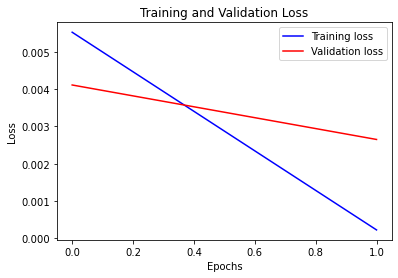

In [55]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

Prediction using the trained model

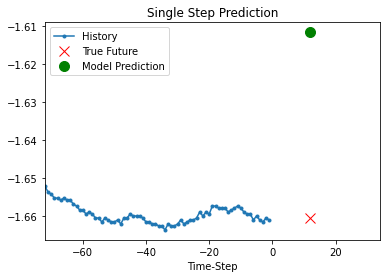

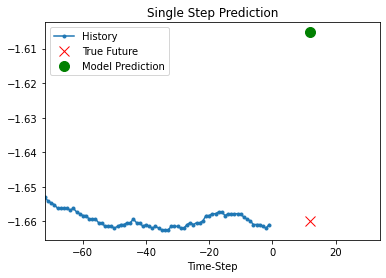

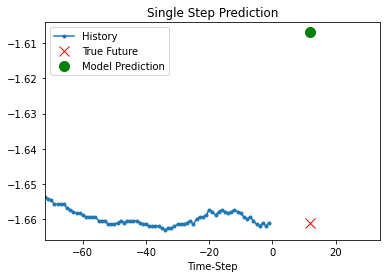

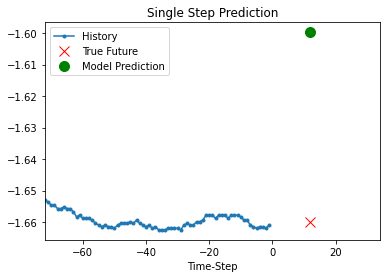

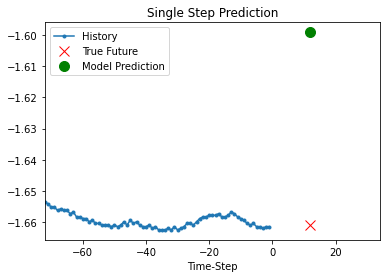

In [60]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[1][:, 1].numpy(), y[1].numpy(), model.predict(x)[1]],
        12,
        "Single Step Prediction",
    )